## 3-Way ANOVA

The three-way ANOVA is an extension of the two-way ANOVA for assessing whether there is an interaction effect between three independent categorical variables on a continuous outcome variable.

We’ll use the **headache dataset** [datarium package], which contains the measures of migraine headache episode pain score in 72 participants treated with three different treatments. The participants include 36 males and 36 females. Males and females were further subdivided into whether they were at low or high risk of migraine.

We want to understand how each independent variable (type of treatments, risk of migraine and gender) interact to predict the pain score.

### Descriptive statistics

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats


url = 'https://raw.githubusercontent.com/Grandokoks/Headaches/refs/heads/main/headache.csv'

headaches = pd.read_csv(url)

plt.style.use('classic')

print(headaches.head())

   id gender risk treatment  pain_score
0   1   male  low         X   79.311695
1   2   male  low         X   76.843399
2   3   male  low         X   70.832421
3   4   male  low         X   81.163944
4   5   male  low         X   75.052213


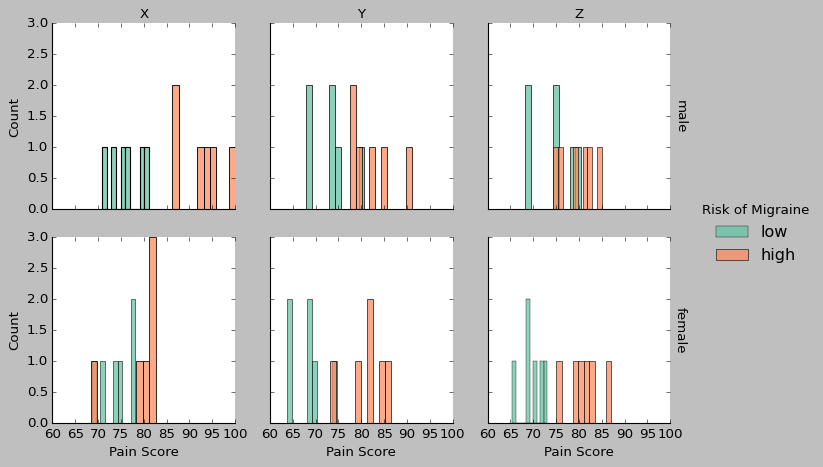

In [3]:
g = sns.FacetGrid(headaches, col="treatment", row="gender", margin_titles=True, hue="risk", palette="Set2")

# Mapping the histograms
g.map_dataframe(sns.histplot, x="pain_score", bins=10, kde=False)

g.set_axis_labels("Pain Score", "Count")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(title="Risk of Migraine")

plt.show()

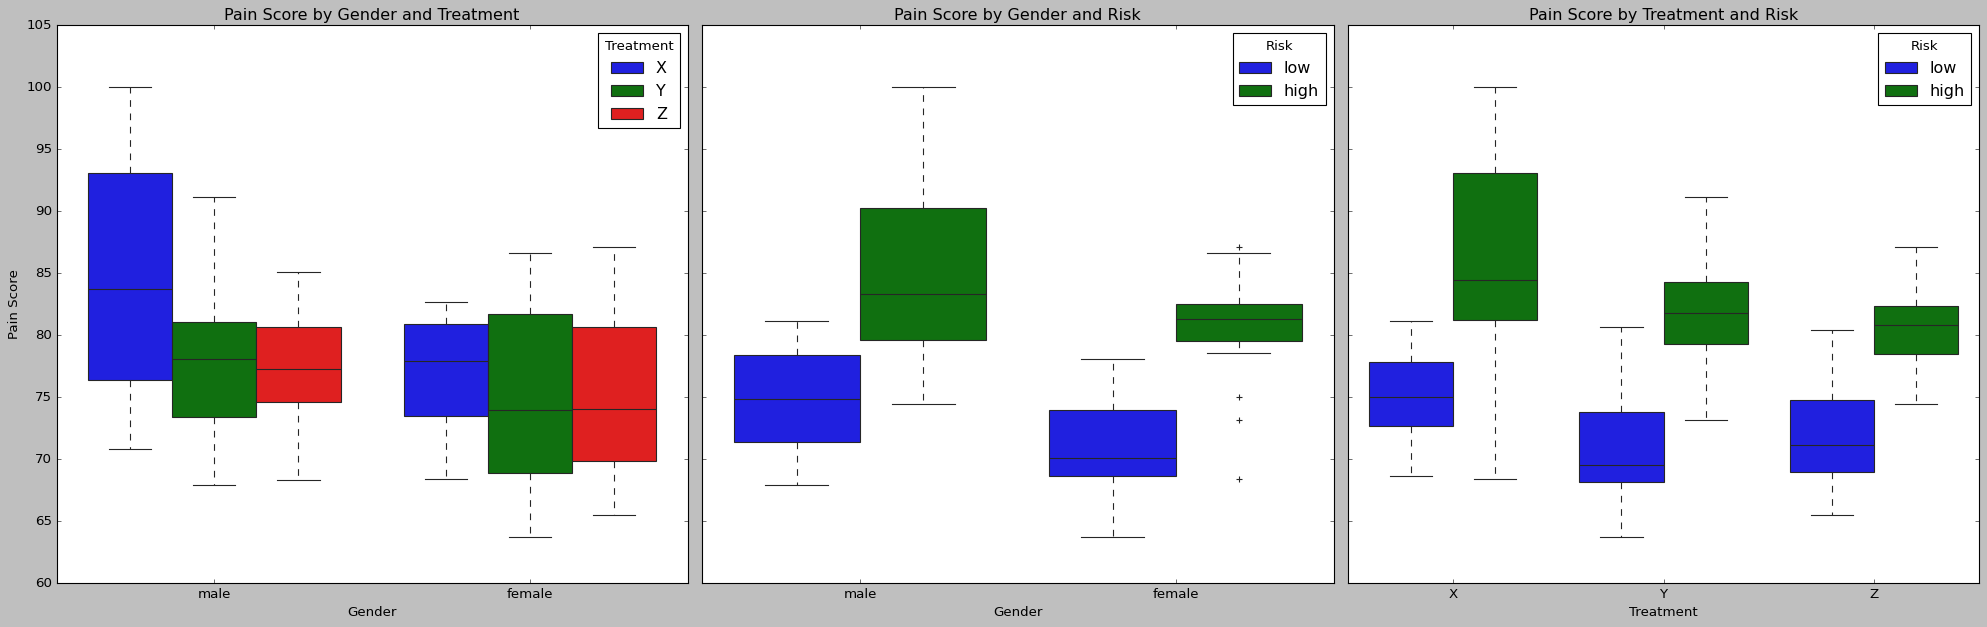

In [ ]:

fig, axes = plt.subplots(1, 3, figsize=(25, 8), sharey=True) 

# Plot 1: Pain Score by Gender and Treatment
sns.boxplot(data=headaches, x='gender', y='pain_score', hue='treatment', ax=axes[0])
axes[0].set_title('Pain Score by Gender and Treatment')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Pain Score')
axes[0].legend(title='Treatment')
axes[0].set_ylim(60, 105) 

# Plot 2: Pain Score by Gender and Risk
sns.boxplot(data=headaches, x='gender', y='pain_score', hue='risk', ax=axes[1])
axes[1].set_title('Pain Score by Gender and Risk')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('') 
axes[1].legend(title='Risk')
axes[1].set_ylim(60, 105)  

# Plot 3: Pain Score by Treatment and Risk
sns.boxplot(data=headaches, x='treatment', y='pain_score', hue='risk', ax=axes[2])
axes[2].set_title('Pain Score by Treatment and Risk')
axes[2].set_xlabel('Treatment')
axes[2].set_ylabel('')  
axes[2].legend(title='Risk')
axes[2].set_ylim(60, 105)  

plt.tight_layout()
plt.show()


In [5]:
summary_stats = headaches.groupby(['gender', 'treatment','risk' ])['pain_score'].agg(['mean', 'std']).reset_index()

summary_stats.columns = ['gender', 'treatment','risk', 'mean_score', 'std_score']
print(summary_stats)

    gender treatment  risk  mean_score  std_score
0   female         X  high   78.865059   5.316489
1   female         X   low   74.156231   3.690272
2   female         Y  high   81.175304   4.619387
3   female         Y   low   68.361925   4.081842
4   female         Z  high   81.035142   3.984886
5   female         Z   low   69.779555   2.719645
6     male         X  high   92.738847   5.116095
7     male         X   low   76.051783   3.854876
8     male         Y  high   82.341542   5.000898
9     male         Y   low   73.138772   4.765061
10    male         Z  high   79.680736   4.045885
11    male         Z   low   74.455863   4.888865


## Assumptions

### Outliers

In [6]:
def identify_outliers(group):
    Q1 = group['pain_score'].quantile(0.25)
    Q3 = group['pain_score'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = group[(group['pain_score'] < lower_bound) | (group['pain_score'] > upper_bound)]
    return outliers

outliers = headaches.groupby(['gender', 'risk', 'treatment']).apply(identify_outliers).reset_index(drop=True)
print(outliers)

   id  gender  risk treatment  pain_score
0  57  female  high         X   68.360185
1  62  female  high         Y   73.144392
2  67  female  high         Z   74.988057
3  71  female  high         Z   87.142265


C:\Users\tsbla\AppData\Local\Temp\ipykernel_10280\275452544.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers = headaches.groupby(['gender', 'risk', 'treatment']).apply(identify_outliers).reset_index(drop=True)


We identify the 4 points as outliers, we can also see them one the plot in the middle that I showed above 

### Normality

In [7]:
from scipy.stats import shapiro

def shapiro_test(group):
    stat, p_value = shapiro(group['pain_score'])
    return pd.Series({'W': stat, 'p_value': p_value})

shapiro_results = headaches.groupby(['gender', 'treatment','risk']).apply(shapiro_test).reset_index()

print(shapiro_results)


    gender treatment  risk         W   p_value
0   female         X  high  0.714180  0.008690
1   female         X   low  0.932551  0.599938
2   female         Y  high  0.939332  0.653824
3   female         Y   low  0.926774  0.555428
4   female         Z  high  0.971232  0.900604
5   female         Z   low  0.957585  0.800946
6     male         X  high  0.958434  0.807595
7     male         X   low  0.982194  0.961928
8     male         Y  high  0.901730  0.384257
9     male         Y   low  0.920272  0.507324
10    male         Z  high  0.955478  0.784303
11    male         Z   low  0.924051  0.535007


C:\Users\tsbla\AppData\Local\Temp\ipykernel_10280\129671246.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shapiro_results = headaches.groupby(['gender', 'treatment','risk']).apply(shapiro_test).reset_index()


All distributions seems to be normal except females with high risk and treated in X way.

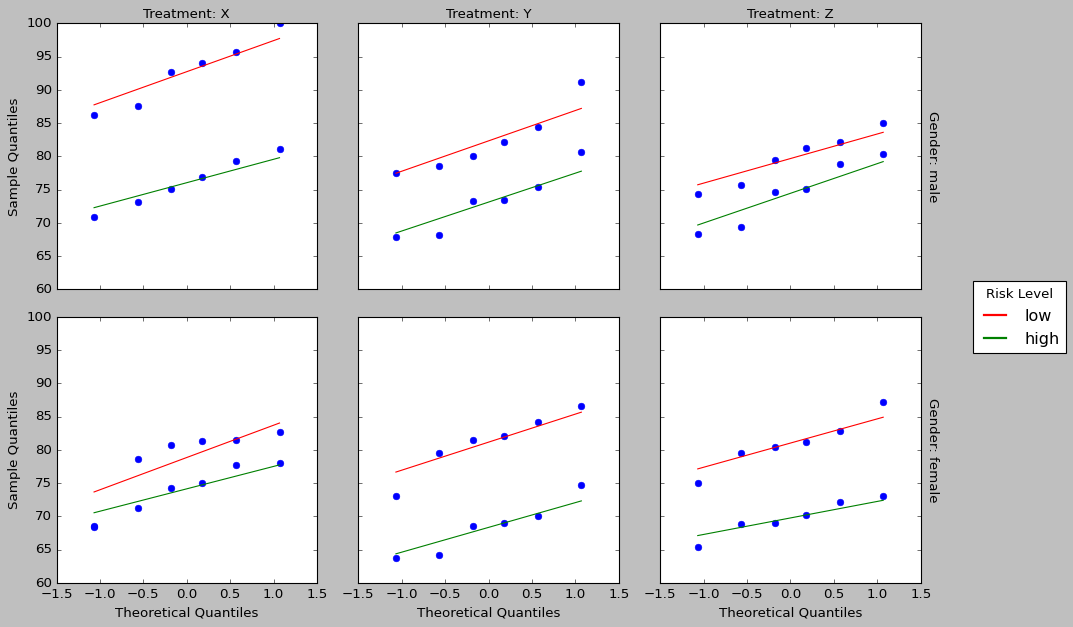

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

def qqplot(x, label=None, **kwargs):
    ax = plt.gca()
    sm.qqplot(x, line='s', ax=ax)
    if label == 'low': 
        ax.get_lines()[1].set_color('red')
    elif label == 'high':  
        ax.get_lines()[1].set_color('green')
    ax.get_lines()[1].set_label(label)

g = sns.FacetGrid(
    headaches, 
    col="treatment", 
    row="gender", 
    margin_titles=True, 
    height=4, 
    hue="risk", 
    despine=False
)

g.map(qqplot, 'pain_score')
g.set_axis_labels("Theoretical Quantiles", "Sample Quantiles")
g.set_titles(col_template="Treatment: {col_name}", row_template="Gender: {row_name}")
plt.legend(
    handles=[plt.Line2D([0], [0], color='red', lw=2, label='low'), plt.Line2D([0], [0], color='green', lw=2, label='high')],
    title="Risk Level",
    bbox_to_anchor=(1.2, 1), loc='center left', borderaxespad=0.
)
plt.show()


## Homogenity of variance

Beacause one of the subgroups is not perfectly normal the best way to check the homogenity is to perform the Levene's test, due to it's robustness to the deviations from normality

In [9]:
from scipy.stats import levene

grouped_data = headaches.groupby(['gender', 'risk','treatment'])['pain_score'].apply(list)

stat, p_value = levene(*grouped_data)

print(f"Levene's test statistic: {stat}")
print(f"p-value: {p_value}")

Levene's test statistic: 0.17859528084995527
p-value: 0.9982136500456726


P-value is very high, so we fail to reject the null hypothesis from the Levene's test which would state that the variances accross groups are equal. 

We can conclude that the variances between the subgroups are approximately equal.

# Anova


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = smf.ols('pain_score ~ gender * treatment * risk', data=headaches).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

print(anova_results)

                            sum_sq    df          F        PR(>F)
gender                  313.358773   1.0  16.195746  1.625409e-04
treatment               283.168031   2.0   7.317679  1.432844e-03
risk                   1793.555757   1.0  92.698774  8.799980e-14
gender:treatment        129.182324   2.0   3.338353  4.220011e-02
gender:risk               2.730584   1.0   0.141128  7.084867e-01
treatment:risk           27.595016   2.0   0.713115  4.942214e-01
gender:treatment:risk   286.595625   2.0   7.406255  1.334476e-03
Residual               1160.892871  60.0        NaN           NaN


## Interpretation

**Gender**: p=0.000162. Statistically significant effect of gender on pain score. Strong evidence that gender influences pain score.

**Treatment**: p=0.00143: Statistically significant effect of treatment on pain score. Different treatments likely lead to different average pain scores.

**Risk**: p<0.000001: Highly significant effect of risk on pain score. Risk level has a substantial influence on pain score.

### Two-Way Interactions
**Gender : Treatment**: p=0.042: Statistically significant interaction between gender and treatment. The effect of treatment on pain score depends on gender.

**Gender : Risk**: p=0.708: Not significant (p-value far greater than 0.05). No evidence that the effect of risk on pain score depends on gender.

**Treatment : Risk**: p=0.494: Not significant (p-value far greater than 0.05). No evidence that the effect of treatment on pain score depends on risk.

### Three-Way Interaction
**Gender : Treatment : Risk**: p=0.00133: Statistically significant interaction. The combined effect of gender, treatment, and risk influences pain score.


In summary, the ANOVA results suggest that gender, risk level and a type of treatment have significant effects on pain scores, and there is also a significant interaction effect only between gender and treatment and between all three of them combined.

# Post-hoc tests

### Significant one-way interactions 

From the ANOVA results we can see that there is a significant main effect of gender and risk on pain scores, howevr As there are only two possibilities in gender and risk there is no point in running the tukey test for them. Let's do one considering pain_score for specific tratement type:

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     X      Y  -4.1986 0.1242 -9.2716 0.8744  False
     X      Z  -4.2152 0.1222 -9.2881 0.8578  False
     Y      Z  -0.0166    1.0 -5.0895 5.0564  False
---------------------------------------------------


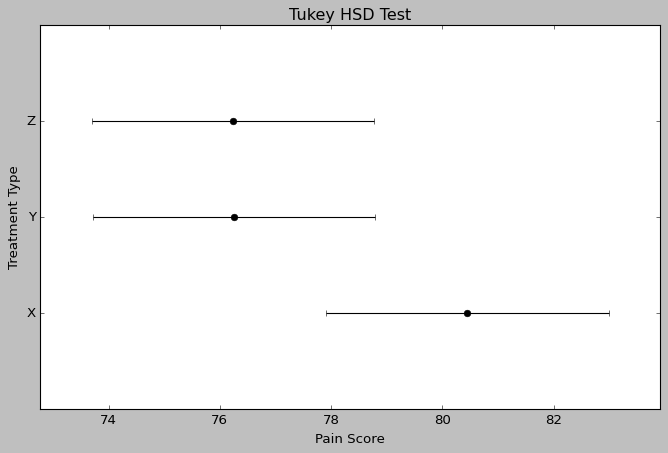

In [11]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=headaches['pain_score'], groups=headaches['treatment'], alpha=0.05)
print(tukey)
tukey.plot_simultaneous()
plt.title('Tukey HSD Test')
plt.xlabel('Pain Score')
plt.ylabel('Treatment Type')
plt.show()


For treatment we did not find the statistical prof that one group differs from the others. The tukey's hsd test did not confirm significant pairwise differences, but from the chart we can see that patients who undergo the X treatment have on average higer pain_score that the patietns with Y or Z treatments who have approximatelly the same mean (77.9 for Y 77.8 for Z and 82.1 for X).

### Significant two-way interactions

As the Treatment X risk and Risk x Gender are not statistically significant we can skip the post-hoc analysis for them.

We will perform one way ANOVA of treatment type at each level of genders: 

In [12]:
from scipy.stats import f_oneway, ttest_ind

from statsmodels.stats.anova import anova_lm

def group_anova(group):
    model = smf.ols('pain_score ~ treatment', data=group).fit()
    return anova_lm(model, typ=2)

anova_results = headaches.groupby('gender').apply(group_anova).reset_index()
print(anova_results)


   gender    level_1       sum_sq    df         F    PR(>F)
0  female  treatment    18.639649   2.0  0.211388  0.810547
1  female   Residual  1454.927406  33.0       NaN       NaN
2    male  treatment   393.710706   2.0  3.576346  0.039281
3    male   Residual  1816.442447  33.0       NaN       NaN


C:\Users\tsbla\AppData\Local\Temp\ipykernel_10280\3382270867.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  anova_results = headaches.groupby('gender').apply(group_anova).reset_index()


From above we can conclude that there exist a significant relationship **only** between males and treatment type (p = 0.04) . For females it is statistically insignificant (p = 0.81).

So we can perform the tukey on males with respect to the treatment:

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     X      Y  -6.6552 0.0865 -14.0873  0.777  False
     X      Z   -7.327  0.054 -14.7592 0.1052  False
     Y      Z  -0.6719 0.9733   -8.104 6.7603  False
----------------------------------------------------


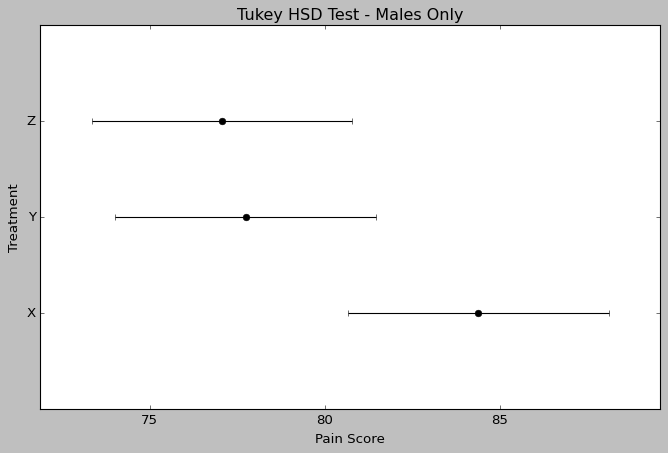

In [13]:
males_data = headaches[headaches['gender'] == 'male']
tukey_males = pairwise_tukeyhsd(endog=males_data['pain_score'], groups=males_data['treatment'], alpha=0.05)
print(tukey_males)

tukey_males.plot_simultaneous()
plt.title('Tukey HSD Test - Males Only')
plt.xlabel('Pain Score')
plt.ylabel('Treatment')
plt.show()


Unfortunatelly for Gender x Treatmet once again we are not able to prove the statistical difference, but this time, treatment X appears to produce slightly higher pain scores than both Y and Z, as indicated by the negative mean differences.
The adjusted p-value of X is almost significant with a magnitude of 0.054.

### Three-way interactions

In order to analyse the 3-way anova we can inspect 2-way annovas for all the levels of the third factor, which would be a 'risk' in our case.

In [ ]:
high_risk_data = headaches[headaches['risk'] == 'high']
low_risk_data = headaches[headaches['risk'] == 'low']

high_risk_model = smf.ols('pain_score ~ gender * treatment', data=high_risk_data).fit()
high_risk_anova_results = sm.stats.anova_lm(high_risk_model, typ=2)

low_risk_model = smf.ols('pain_score ~ gender * treatment', data=low_risk_data).fit()
low_risk_anova_results = sm.stats.anova_lm(low_risk_model, typ=2)

print('High risk:')
print(high_risk_anova_results )
print()
print('Low risk:')
print(low_risk_anova_results)


High risk
                      sum_sq    df         F    PR(>F)
gender            187.296215   1.0  8.447186  0.006811
treatment         191.795107   2.0  4.325045  0.022365
gender:treatment  399.733382   2.0  9.014123  0.000860
Residual          665.178458  30.0       NaN       NaN

Low risk
                      sum_sq    df         F    PR(>F)
gender            128.793142   1.0  7.794396  0.009031
treatment         118.967940   2.0  3.599894  0.039693
gender:treatment   16.044566   2.0  0.485498  0.620142
Residual          495.714413  30.0       NaN       NaN


As we can see for low risk we have a significant effect for both gender and treatment but unsignificant for them both combined. 
However for high risk gender x treatment seems to be significant so we can investigate it further:

In [18]:

genders = high_risk_data['gender'].unique()

for gender in genders:
    subset = high_risk_data[high_risk_data['gender'] == gender]
    treatments = [subset[subset['treatment'] == t]['pain_score'] for t in subset['treatment'].unique()]
    stat, p_value = f_oneway(*treatments)
    print(f"High Risk - Gender: {gender}, F-statistic: {stat:.3f}, p-value: {p_value:.4f}")


High Risk - Gender: male, F-statistic: 12.688, p-value: 0.0006
High Risk - Gender: female, F-statistic: 0.461, p-value: 0.6392


As we can see there exist a signifcant effect for males only (p-value = 0.0006). Let's run a tukey test to comapare all the subgroups:

Tukey HSD - High Risk - Males:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     X      Y -10.3973 0.0047 -17.5135 -3.2811   True
     X      Z -13.0581 0.0007 -20.1743 -5.9419   True
     Y      Z  -2.6608 0.6054   -9.777  4.4554  False
-----------------------------------------------------


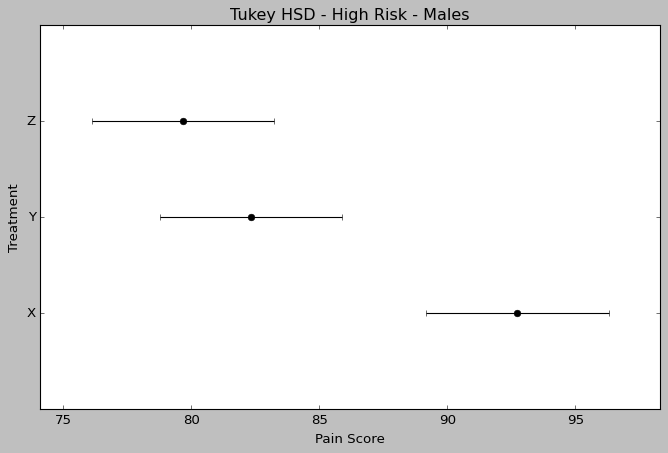

In [19]:
males = high_risk_data[high_risk_data['gender'] == 'male']

tukey_males = pairwise_tukeyhsd(endog=males['pain_score'], groups=males['treatment'], alpha=0.05)

print("Tukey HSD - High Risk - Males:")
print(tukey_males)

tukey_males.plot_simultaneous()
plt.title('Tukey HSD - High Risk - Males')
plt.xlabel('Pain Score')
plt.ylabel('Treatment')
plt.show()

No significant No significant difference was observed between Treatments Y and Z (p=0.6054). 

But Treatment X resulted in significantly higher pain scores compared to both Treatment Y (p=0.0047) and Treatment Z (p=0.0007).

## Final Conclusions
**We can state that using treatment X for males with high risk of migrane leads to a higer pain scores compared to other treatment types.**

Also for all males it is not advised to undergo the X treatment in order to avoid high pain scores, but we do not find a certain statistical prove to confirm it (p-value was slightly higer than 0.05).